In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

Initialize parameters.

In [2]:
nh = 8
refRatio = 2
c = 1.
CFL = 0.5
nt = 6
RK = 4
deriv = 'CD'
order = 1

In [4]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)

In [22]:
def ModeProp(omega, nt, c, deriv):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    
    if (RK == 1):
        TimeIntegratorFunc = ST.ForwardEuler
    else:
        if (RK == 2):
            TimeIntegratorFunc = ST.MidpointMeth
        else:
            TimeIntegratorFunc = ST.RK4

    if (deriv == 'U'):
        # DiffMatFunc = OT.Upwind1D
        DiffFunc = TT.Upwind#ST.Upwind
    else:
        # DiffMatFunc = OT.CenterDiff1D
        DiffFunc = TT.CenterDiff#ST.CenterDiff

    t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
    derivMat = OT.SpaceDeriv(omega, order, deriv)
    spatOp = -c * derivMat
    strings = omega.strings
    timePropOp = LA2.expm(t * spatOp)
    waves = WT.MakeWaves(omega)
    omegaF = BT.Grid(nh_max)
    wavesF = WT.MakeWaves(omegaF)
    restrictOp = GTT.CoarsenOp(omega)
    nullspace = OT.FindNullspace(omega, waves)
    
    FCoefsF = np.eye(nh_max)# [:, :nh_min]
    FCoefs = np.zeros((degFreed, nh_max), float)
    propFCoefs = np.zeros((degFreed, nh_max), float)
    solvFCoefs = np.zeros((degFreed, nh_max), float)
    exTimeCoefs = np.zeros((degFreed, nh_max), float)
    
#     print('derivMat =\n', derivMat, '\n')
#     print('spatOp =\n', spatOp, '\n')
#     print('timePropOp =\n', timePropOp, '\n')

    for k in range(nh_max):
        print()
        waveformF = wavesF @ # nullspace[:, k]
        propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c, t)
        waveform = restrictOp @ waveformF
        FCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

        solvFCoefs[:, k] = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
        exTimeForm = timePropOp @ waveform
        exTimeCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)


#         labels[k] = [r'$u_{0} (x)$', r'Exact $u_{0} (x - c t)$', r'Exact Time $u_{0} (x - c t)$', r'Time Integrator $u_{0} (x - c t)$']
#         allCoefs = nullspace @ PT.Load(FCoefs[:, k], PropFCoefs[:, k], exTimeCoefs[:, k], solverCoefs[:, k])
#         if (showPlots):
#             PT.PlotMixedWave(omega, waves, allCoefs, rescale = [4, 6], labels = labels[k], yGrid = True, dpi = 300)
    FCoefs = nullspace @ FCoefs
    propFCoefs = nullspace @ propFCoefs
    solvFCoefs = nullspace @ solvFCoefs
    exTimeCoefs = nullspace @ exTimeCoefs
    return FCoefs, propFCoefs, solvFCoefs, exTimeCoefs


In [23]:
def ModeError(omega, nt, c, deriv, normType = 'max', errorType = 'absolute', inclNull = False):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    FCoefs, propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, deriv)
    solvError = np.zeros(nh_max, float)
    exTimeError = np.zeros(nh_max, float)
    for k in range(nh_max):
        ks, solvErrorVec = TT.AmpError(omega, propFCoefs[:, k], solvFCoefs[:, k])
        ks, exTimeErrorVec = TT.AmpError(omega, propFCoefs[:, k], exTimeCoefs[:, k])
        if (normType == 'max'):
            solvError[k] = max(solvErrorVec)
            exTimeError[k] = max(exTimeErrorVec)
        else:
            solvError[k] = sum(solvErrorVec) / nh
            exTimeError[k] = sum(exTimeErrorVec) / nh
#     if (not inclNull):
#         ks = ks[:nh_min]
#         solvError = solvError[:nh_min]
#         exTimeError = exTimeError[:nh_min]
    return ks, solvError, exTimeError

In [24]:
ks, solvError, exTimeError = ModeError(omega, nt, c, deriv)


IndexError: index 12 is out of bounds for axis 1 with size 12

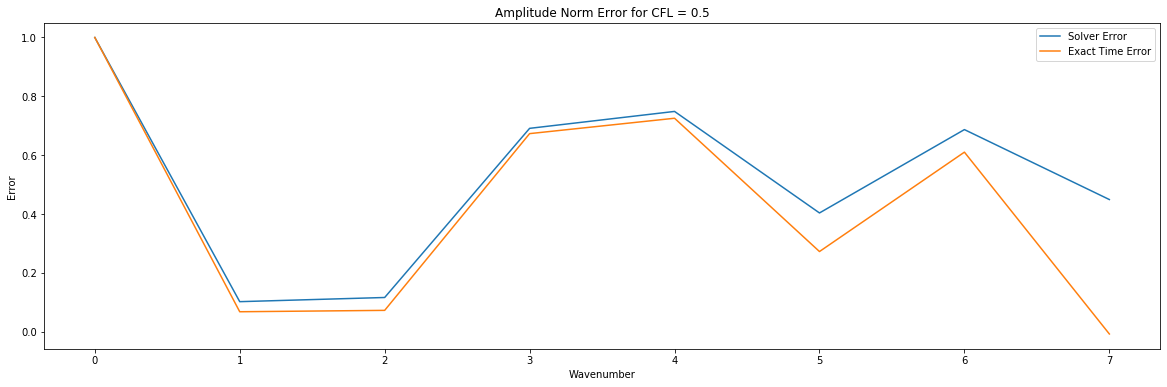

In [19]:
title = 'Amplitude Norm Error for CFL = ' + str(CFL)
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvError, label = 'Solver Error', color = PT.ColorDefault(0))
plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
plt.title('Amplitude Norm Error for CFL = ' + str(CFL))
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
plt.show()

In [11]:
for k in range(3,9-3):
    print(k)

3
4
5


In [9]:
stringsVal = PT.FixStrings(omega, nullspace, True)
print(stringsVal)

NameError: name 'nullspace' is not defined

In [16]:
A = np.arange(12).reshape(3, 4)
print(A)
print(A[:3])

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
